In [39]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.utils import to_categorical

In [40]:
df_ncc = pd.read_csv("./ncc.binetflow")
df_ncc=df_ncc[~df_ncc['Label'].str.contains("Background", case=False, na=False)]
df_ncc = df_ncc.sample(25000)
df_iot = pd.read_csv("./iot23.csv").sample(25000)
df_ctu = pd.read_csv("./ctu.csv").sample(25000)
df_ctu=df_ctu[~df_ctu['Label'].str.contains("Background", case=False, na=False)]
df_ctu = df_ctu.sample(25000)

C:\Users\tejas\AppData\Local\Temp\ipykernel_12828\157375421.py:1: DtypeWarning: Columns (1,9,10,11,12,13,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ncc = pd.read_csv("./ncc.binetflow")
C:\Users\tejas\AppData\Local\Temp\ipykernel_12828\157375421.py:4: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iot = pd.read_csv("./iot23.csv").sample(25000)
C:\Users\tejas\AppData\Local\Temp\ipykernel_12828\157375421.py:5: DtypeWarning: Columns (5,8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ctu = pd.read_csv("./ctu.csv").sample(25000)


In [42]:
df_iot['ActivityLabel'] = df_iot['label'].apply(lambda x: 0 if x == 'Benign' else 1)
df_iot = df_iot.drop(columns=['label'])
df_ctu['ActivityLabel'] = df_ctu['BOTNET'].apply(lambda x: 0 if x == 0 else 1)
df_ctu = df_ctu.drop(columns=['BOTNET'])

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def plot_traffic_graph(df, src_col, dst_col, activity_col,dataset_name):
    df= df.head(5000)
    # Create the directed graph
    G = nx.Graph()
    # Add edges to the graph
    for _, row in df.iterrows():
        G.add_edge(row[src_col], row[dst_col], activity=row['ActivityLabel'])

    # Define node colors based on the ActivityLabel
    node_colors = []
    for node in G.nodes:
        if node in df[src_col].values:
            activity = df[df[src_col] == node]['ActivityLabel'].values[0]
        elif node in df[dst_col].values:
            activity = df[df[dst_col] == node]['ActivityLabel'].values[0]
        else:
            activity = 0  # Default to normal if no activity is found

        if activity == 1:
            node_colors.append('red')  # Botnet node
        else:
            node_colors.append('blue')  # Normal node

    # Draw the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx(G, node_color=node_colors, with_labels=False, node_size=50)
    plt.title(f'Network Traffic with Botnet (Red) and Normal (Blue) Nodes for {dataset_name}')
    plt.show()

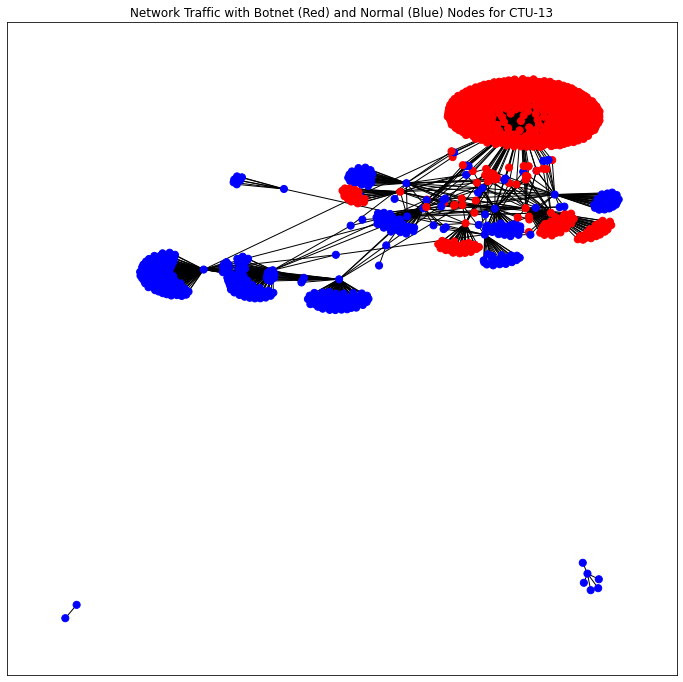

In [5]:
plot_traffic_graph(df_ctu,"SrcAddr","DstAddr","ActivityLabel","CTU-13")

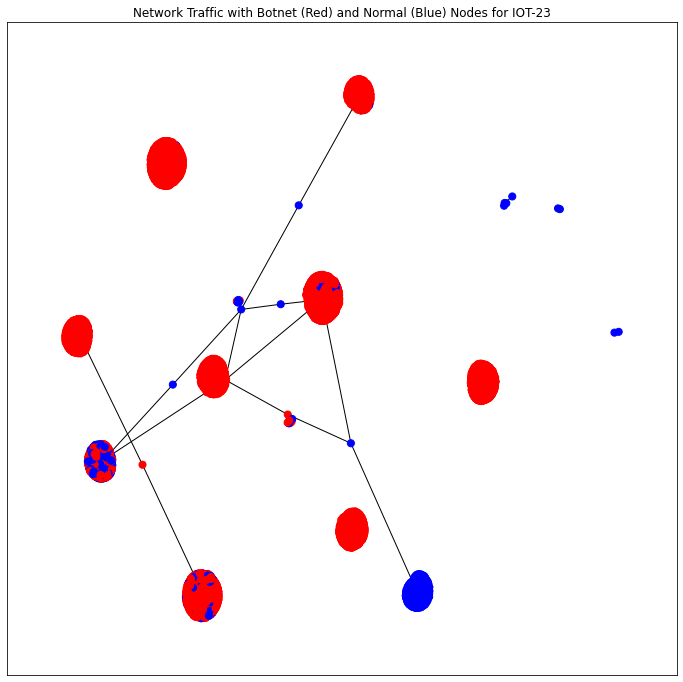

In [43]:
plot_traffic_graph(df_iot,"id.orig_h","id.resp_h","ActivityLabel","IOT-23")

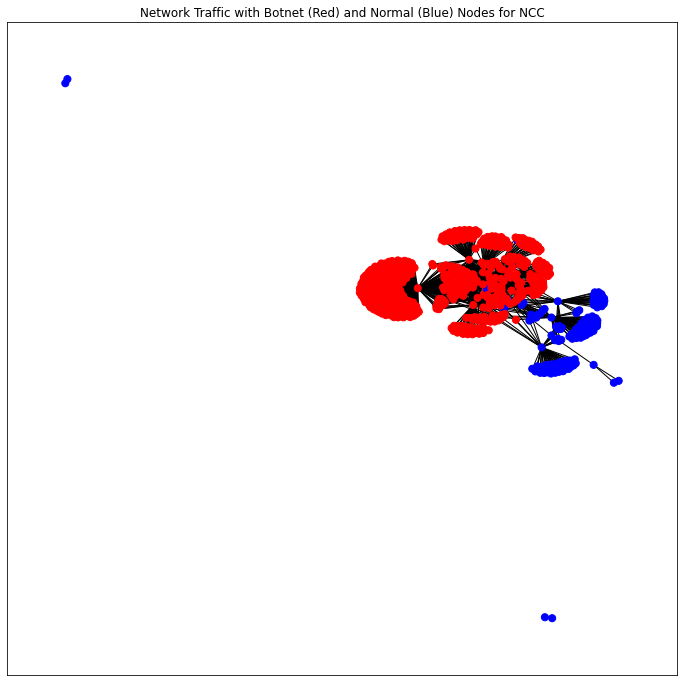

In [7]:
plot_traffic_graph(df_ncc,"SrcAddr","DstAddr","ActivityLabel","NCC")

In [5]:
from sklearn.preprocessing import MinMaxScaler

def calculate_additional_graph_metrics(G):
    # Calculate in-degree and out-degree
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())

    # Calculate eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

    # Calculate betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)

    return in_degree, out_degree, eigenvector_centrality, betweenness_centrality


def convert_categorical_to_numeric(df):
    le = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':
            df[column] = le.fit_transform(df[column])
    return df

def convert_categorical_to_numeric(df,src_col="SrcAddr",dst_col="DstAddr"):
    le = LabelEncoder()
    encoding_maps = {}
    for column in df.columns:
        if column == src_col or column == dst_col:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = le.fit_transform(df[column])
                encoding_maps[column] = dict(zip(le.transform(le.classes_), le.classes_))
        else:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = df[column].astype(str)
                df[column] = le.fit_transform(df[column])
    return df, encoding_maps

def feature_selection_vif(dataset, srcLabel, dstLabel, alpha=0.005, vif_threshold=20):
    # Load and clean the dataset
    df = dataset
    df = df.drop_duplicates()
    df = df.dropna()

    df['ActivityLabel'] = df['ActivityLabel'].apply(lambda x: 0 if x == 0 else 1)

    # Convert non-numeric features to numeric
    df, maps = convert_categorical_to_numeric(df,srcLabel,dstLabel)

    # Create the graph from IPs
    ips = df[[srcLabel, dstLabel]]
    G = nx.DiGraph()
    for _, row in ips.iterrows():
        G.add_edge(row[srcLabel], row[dstLabel])

    # Calculate centrality metrics
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    def refined_normalize(metric):
        values = np.array(list(metric.values()))
        if len(values) == 0 or values.max() == values.min():
            return dict(zip(metric.keys(), values))
        percentiles = np.percentile(values, np.linspace(0, 100, 101))
        normalized_values = np.interp(values, percentiles, np.linspace(0, 1, 101))
        return dict(zip(metric.keys(), normalized_values))

    degree_centrality_norm = refined_normalize(degree_centrality)
    closeness_centrality_norm = refined_normalize(closeness_centrality)
    betweenness_centrality_norm = refined_normalize(betweenness_centrality)

    # Compute Composite Node Importance (CNI)
    cni_scores = {}
    for node in G.nodes():
        cni_scores[node] = (degree_centrality_norm.get(node, 0) +
                            closeness_centrality_norm.get(node, 0) +
                            betweenness_centrality_norm.get(node, 0)) / 3

    # Calculate additional graph metrics
    in_degree, out_degree, eigenvector_centrality, betweenness_centrality = calculate_additional_graph_metrics(G)

    # Add CNI scores and other metrics to the dataset
    dataset_with_metrics = df.copy()
    dataset_with_metrics['orig_h_CNI'] = dataset_with_metrics[srcLabel].map(cni_scores)
    dataset_with_metrics['resp_h_CNI'] = dataset_with_metrics[dstLabel].map(cni_scores)
    dataset_with_metrics['average_CNI'] = dataset_with_metrics[['orig_h_CNI', 'resp_h_CNI']].mean(axis=1)

    ip_cni_map = {ip: cni_scores[ip] for ip in cni_scores if ip in dataset_with_metrics[srcLabel].unique() or ip in dataset_with_metrics[dstLabel].unique()}
    df_final = dataset_with_metrics

    # Normalize the features
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)

    # Calculate traditional VIF
    def calculate_vif(df):
        df = df.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
        X = df.values
        vif_scores = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        vif_data = pd.DataFrame({'Feature': df.columns, 'Traditional_VIF': vif_scores})
        return vif_data

    
    start_time_1 = time()
    vif_results = calculate_vif(df_normalized)
    vif_time = time() - start_time_1
    vif_scores = vif_results

    # Iterative VIF-based feature selection
    features_to_remove = []
    high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()
    while high_vif_features:
        feature_to_remove = high_vif_features[0]
        features_to_remove.append(feature_to_remove)
        vif_results = vif_results[vif_results['Feature'] != feature_to_remove]
        remaining_features = vif_results['Feature'].tolist()
        X_subset = df_normalized[remaining_features]
        vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
        high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()

    # Calculate Modified VIF
    def calculate_modified_vif(X, alpha):
        X = X.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
        
        features = X.columns
        mvif_data = []
        for feature in features:
            predictors = [feat for feat in features if feat != feature]
            model = LinearRegression().fit(X[predictors], X[feature])
            r_squared = model.score(X[predictors], X[feature])
            average_cni_mean = dataset_with_metrics['average_CNI'].mean()
            # Normalizing the adjustment term
            normalized_adjustment = (r_squared + alpha * average_cni_mean) / (1 + alpha * average_cni_mean)
        
            if normalized_adjustment >= 1.0:
                normalized_adjustment = 1.0 - 1e-6  # Adjust to avoid negative or zero denominator

            modified_vif = 1 / (1 - normalized_adjustment)
            mvif_data.append({'Feature': feature, 'Modified_VIF': modified_vif})
        
        return pd.DataFrame(mvif_data)

    X = df_normalized
    start_time_1 = time()
    mvif_results = calculate_modified_vif(X, alpha)
    mvif_time = time() - start_time_1

    final_vif_results = pd.merge(vif_scores, mvif_results, on='Feature')
    selected_features = mvif_results[mvif_results['Modified_VIF'] < vif_threshold]['Feature'].tolist()
    selected_features_vif = vif_results[vif_results['Traditional_VIF'] < vif_threshold]['Feature'].tolist()

    return df_final, final_vif_results,mvif_time,vif_time,selected_features,selected_features_vif,maps,ip_cni_map


In [33]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from time import time
from scipy.stats import norm

def compute_confidence_interval(proportion, n, confidence_level=0.95):
    """Compute confidence interval and standard error for a given proportion."""
    if n == 0:
        return (0, 0), 0  # Return 0 confidence interval if n is 0
    z_score = norm.ppf((1 + confidence_level) / 2)  # Z-score for the confidence level
    standard_error = np.sqrt((proportion * (1 - proportion)) / n)
    margin_of_error = z_score * standard_error
    ci_lower = max(0, proportion - margin_of_error)  # Ensure no negative values
    ci_upper = min(1, proportion + margin_of_error)  # Ensure no values above 1
    return (ci_lower, ci_upper), standard_error

def train_model_and_plot(df_final, dataset_name, selected_features, srcLabel="SrcAddr", dstLabel="DstAddr", k_folds=5):
    results = {
        'model_performance': {},
        'final_results': {}
    }
    
    # Splitting data into features and target
    features = selected_features
    label_col = "ActivityLabel"
    
    X = df_final[features]
    y = df_final[label_col]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize model
    model = RandomForestClassifier(random_state=42)

    # Stratified K-Fold Cross Validation
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    precision_list, recall_list, f1_list = [], [], []
    accuracy_list = []
    
    # K-Fold Cross Validation loop
    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Collect metrics
        accuracy_list.append(accuracy_score(y_test, y_pred))
        precision_list.append(precision_score(y_test, y_pred))
        recall_list.append(recall_score(y_test, y_pred))
        f1_list.append(f1_score(y_test, y_pred))

    # Calculate confidence intervals and errors for the metrics
    accuracy_ci, accuracy_error = compute_confidence_interval(np.mean(accuracy_list), len(y))
    precision_ci, precision_error = compute_confidence_interval(np.mean(precision_list), len(y))
    recall_ci, recall_error = compute_confidence_interval(np.mean(recall_list), len(y))
    f1_ci, f1_error = compute_confidence_interval(np.mean(f1_list), len(y))

    # Store results
    results['model_performance']['Random Forest'] = {
        'accuracy': np.mean(accuracy_list),
        'accuracy_confidence_interval': accuracy_ci,
        'accuracy_error': accuracy_error,
        'precision': np.mean(precision_list),
        'precision_confidence_interval': precision_ci,
        'precision_error': precision_error,
        'recall': np.mean(recall_list),
        'recall_confidence_interval': recall_ci,
        'recall_error': recall_error,
        'f1_score': np.mean(f1_list),
        'f1_confidence_interval': f1_ci,
        'f1_error': f1_error,
        'accuracy_list': accuracy_list,
        'precision_list': precision_list,
        'recall_list': recall_list,
        'f1_list': f1_list
    }

    # Use the model to predict on the full dataset
    df_clone = df_final.copy()
    X_full = df_clone[selected_features]
    
    # Standardize the full dataset features
    X_full_scaled = scaler.transform(X_full)
    
    # Predict on full dataset
    start_time = time()
    y_pred_full = model.predict(X_full_scaled)
    prediction_time = time() - start_time

    # Add predicted labels to the dataset
    df_clone['Predicted_Label'] = y_pred_full
    botnet_df = df_clone[df_clone['Predicted_Label'] == 1]

    # Calculate additional metrics
    total_records = len(df_clone)
    actual_botnet = len(df_clone[df_clone[label_col] == 1])
    predicted_botnet = len(botnet_df)
    correctly_identified = len(df_clone[(df_clone[label_col] == 1) & (df_clone['Predicted_Label'] == 1)])
    detection_rate = (correctly_identified / actual_botnet * 100) if actual_botnet > 0 else 0

    # Graph visualization for botnet nodes
    G = nx.Graph()
    for index, row in botnet_df.iterrows():
        if row[srcLabel] != 'Unknown' and row[dstLabel] != 'Unknown':
            G.add_edge(row[srcLabel], row[dstLabel])

    # Plot the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
    nx.draw(G, pos, node_size=50, node_color='r', alpha=0.5)
    plt.title(f'Botnet Nodes Graph for {dataset_name}')
    plt.show()

    # Store final results
    results['final_results'] = {
        'total_records': total_records,
        'actual_botnet_records': actual_botnet,
        'predicted_botnet_records': predicted_botnet,
        'correctly_identified_botnet': correctly_identified,
        'detection_rate_percentage': detection_rate,
        'false_positives': predicted_botnet - correctly_identified,
        'false_negatives': actual_botnet - correctly_identified,
        'accuracy': accuracy_score(df_clone[label_col], df_clone['Predicted_Label']),
        'accuracy_confidence_interval': accuracy_ci,
        'accuracy_error': accuracy_error,
        'precision': precision_score(df_clone[label_col], df_clone['Predicted_Label']),
        'precision_confidence_interval': precision_ci,
        'precision_error': precision_error,
        'recall': recall_score(df_clone[label_col], df_clone['Predicted_Label']),
        'recall_confidence_interval': recall_ci,
        'recall_error': recall_error,
        'f1_score': f1_score(df_clone[label_col], df_clone['Predicted_Label']),
        'f1_confidence_interval': f1_ci,
        'f1_error': f1_error,
        'accuracy_list': accuracy_list,
        'precision_list': precision_list,
        'recall_list': recall_list,
        'f1_list': f1_list,
        'confusion_matrix': confusion_matrix(df_clone[label_col], df_clone['Predicted_Label']).tolist(),
        'graph_statistics': {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges()
        },
        'computation_time': {
            'prediction_time': prediction_time
        }
    }

    return botnet_df, results['final_results']


In [34]:
def final_result(df,dataset_name,srcLabel="SrcAddr",dstLabel="DstAddr"):
    df_final, final_vif_results,mvif_time,vif_time,selected_features,selected_features_vif,maps,ip_cni_map=feature_selection_vif(df,srcLabel,dstLabel)
    return train_model_and_plot(df_final,dataset_name,selected_features,srcLabel,dstLabel)


# Bot Detection using proposed CNI method

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_12828\538808301.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

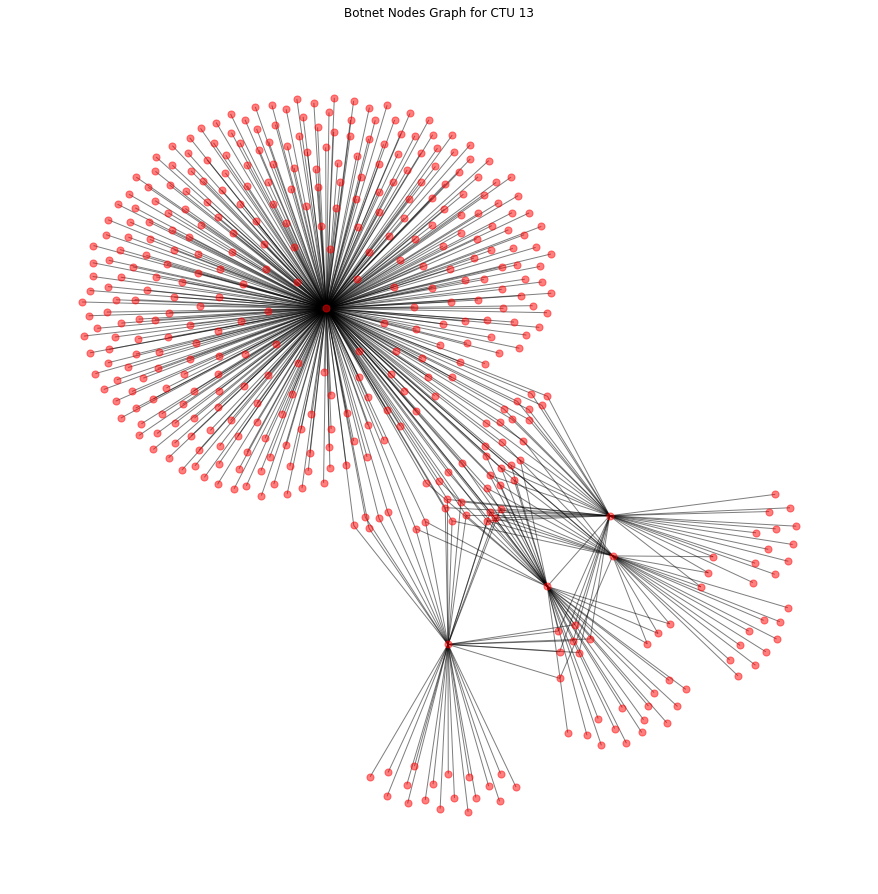

{'total_records': 10162,
 'actual_botnet_records': 3320,
 'predicted_botnet_records': 3320,
 'correctly_identified_botnet': 3320,
 'detection_rate_percentage': 100.0,
 'false_positives': 0,
 'false_negatives': 0,
 'accuracy': 1.0,
 'accuracy_confidence_interval': (1.0, 1),
 'accuracy_error': 0.0,
 'precision': 1.0,
 'precision_confidence_interval': (1.0, 1),
 'precision_error': 0.0,
 'recall': 1.0,
 'recall_confidence_interval': (1.0, 1),
 'recall_error': 0.0,
 'f1_score': 1.0,
 'f1_confidence_interval': (1.0, 1),
 'f1_error': 0.0,
 'accuracy_list': [1.0, 1.0, 1.0, 1.0, 1.0],
 'precision_list': [1.0, 1.0, 1.0, 1.0, 1.0],
 'recall_list': [1.0, 1.0, 1.0, 1.0, 1.0],
 'f1_list': [1.0, 1.0, 1.0, 1.0, 1.0],
 'confusion_matrix': [[6842, 0], [0, 3320]],
 'graph_statistics': {'num_nodes': 436, 'num_edges': 518},
 'computation_time': {'prediction_time': 0.0970296859741211}}

In [24]:
b_df,results_cni_ctu=final_result(df_ctu,"CTU 13")
results_cni_ctu

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_12828\538808301.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\re

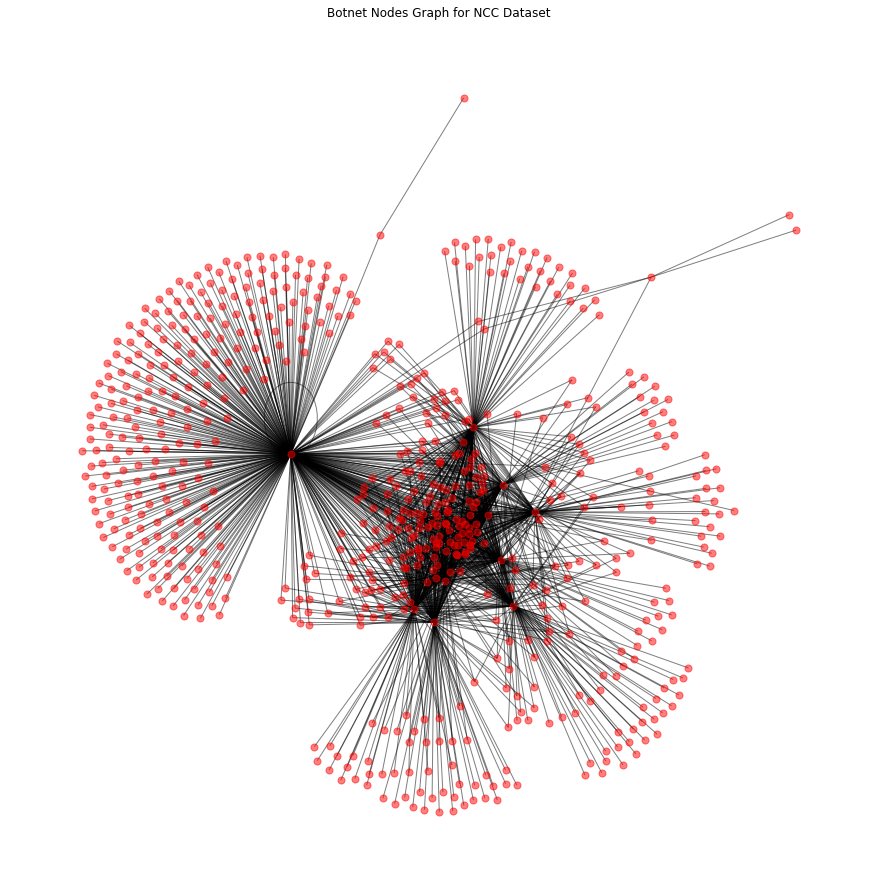

{'total_records': 21481,
 'actual_botnet_records': 16652,
 'predicted_botnet_records': 16651,
 'correctly_identified_botnet': 16651,
 'detection_rate_percentage': 99.99399471534952,
 'false_positives': 0,
 'false_negatives': 1,
 'accuracy': 0.999953447232438,
 'accuracy_confidence_interval': (0.9998622033174736, 1),
 'accuracy_error': 4.655276751157972e-05,
 'precision': 1.0,
 'precision_confidence_interval': (1.0, 1),
 'precision_error': 0.0,
 'recall': 0.9999399471534951,
 'recall_confidence_interval': (0.9998363399034942, 1),
 'recall_error': 5.286733220744363e-05,
 'f1_score': 0.9999699726751344,
 'f1_confidence_interval': (0.99989669884099, 1),
 'f1_error': 3.7386216223620284e-05,
 'accuracy_list': [1.0, 1.0, 1.0, 1.0, 0.9997672253258846],
 'precision_list': [1.0, 1.0, 1.0, 1.0, 1.0],
 'recall_list': [1.0, 1.0, 1.0, 1.0, 0.999699789852897],
 'f1_list': [1.0, 1.0, 1.0, 1.0, 0.9998498723915328],
 'confusion_matrix': [[4829, 0], [1, 16651]],
 'graph_statistics': {'num_nodes': 663, 'n

In [25]:
b_df,results_cni_ncc=final_result(df_ncc,"NCC Dataset")
results_cni_ncc

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_12828\538808301.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\re

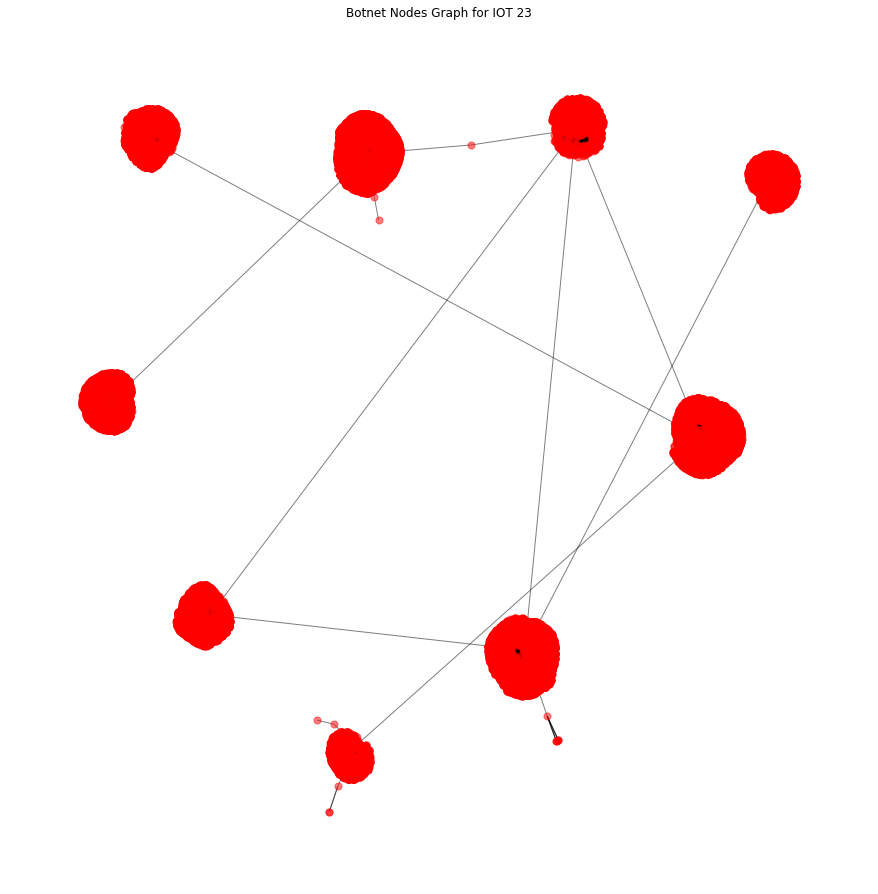

{'total_records': 25000,
 'actual_botnet_records': 21560,
 'predicted_botnet_records': 21560,
 'correctly_identified_botnet': 21560,
 'detection_rate_percentage': 100.0,
 'false_positives': 0,
 'false_negatives': 0,
 'accuracy': 1.0,
 'accuracy_confidence_interval': (1.0, 1),
 'accuracy_error': 0.0,
 'precision': 1.0,
 'precision_confidence_interval': (1.0, 1),
 'precision_error': 0.0,
 'recall': 1.0,
 'recall_confidence_interval': (1.0, 1),
 'recall_error': 0.0,
 'f1_score': 1.0,
 'f1_confidence_interval': (1.0, 1),
 'f1_error': 0.0,
 'accuracy_list': [1.0, 1.0, 1.0, 1.0, 1.0],
 'precision_list': [1.0, 1.0, 1.0, 1.0, 1.0],
 'recall_list': [1.0, 1.0, 1.0, 1.0, 1.0],
 'f1_list': [1.0, 1.0, 1.0, 1.0, 1.0],
 'confusion_matrix': [[3440, 0], [0, 21560]],
 'graph_statistics': {'num_nodes': 18992, 'num_edges': 18992},
 'computation_time': {'prediction_time': 0.37177419662475586}}

In [35]:
b_df,results_cni_iot=final_result(df_iot,"IOT 23","id.orig_h","id.resp_h")
results_cni_iot

In [26]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import random
import time
import scipy.stats as stats

def encode_categorical_columns(data):
    label_encoders = {}
    for col in data.select_dtypes(include=['object', 'category']).columns:
        data[col] = data[col].astype(str)
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
    return data, label_encoders

def preprocess_dataset(data, src_col='id.orig_h', dst_col='id.resp_n'):
    data.dropna(inplace=True)
    data = data.drop_duplicates()
    data, label_encoders = encode_categorical_columns(data)
    return data, label_encoders

def create_graph_and_add_metrics(data, src_col='id.orig_h', dst_col='id.resp_n'):
    graph = nx.DiGraph()
    graph.add_edges_from(data[[src_col, dst_col]].values)
    
    # Graph metrics
    in_degree = dict(graph.in_degree())
    out_degree = dict(graph.out_degree())
    pagerank = nx.pagerank(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    
    # Add graph features
    data['in_degree'] = data[src_col].map(in_degree)
    data['out_degree'] = data[src_col].map(out_degree)
    data['pagerank'] = data[src_col].map(pagerank)
    data['closeness_centrality'] = data[src_col].map(closeness_centrality)
    data['betweenness_centrality'] = data[src_col].map(betweenness_centrality)
    
    return data, graph

def compute_confidence_interval(values, confidence=0.95):
    n = len(values)
    mean = np.mean(values)
    std_err = stats.sem(values)
    margin = stats.norm.ppf((1 + confidence) / 2) * std_err
    return mean, (mean - margin, mean + margin)

def apply_kfold_with_custom_metrics(data, target_col, k=5):
    X = data.drop(columns=[target_col])
    y = data[target_col]
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Metrics calculation
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        tp = cm[1, 1]
        fp = cm[0, 1]
        fn = cm[1, 0]
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        accuracies.append(acc)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # Compute confidence intervals for each metric
    accuracy_mean, accuracy_ci = compute_confidence_interval(accuracies)
    precision_mean, precision_ci = compute_confidence_interval(precisions)
    recall_mean, recall_ci = compute_confidence_interval(recalls)
    f1_mean, f1_ci = compute_confidence_interval(f1_scores)
    
    return {
        'accuracy': accuracy_mean,
        'accuracy_confidence_interval': accuracy_ci,
        'accuracy_values': accuracies,
        'precision': precision_mean,
        'precision_confidence_interval': precision_ci,
        'precision_values': precisions,
        'recall': recall_mean,
        'recall_confidence_interval': recall_ci,
        'recall_values': recalls,
        'f1_score': f1_mean,
        'f1_values': f1_scores,
        'f1_confidence_interval': f1_ci
    }

def final_result(df, src_col, dst_col, target_col, dataset_name):
    print(f"\nProcessing {dataset_name}...")

    # Preprocess dataset
    df, encoder = preprocess_dataset(df, src_col, dst_col)

    # Create graph and add metrics
    df, graph = create_graph_and_add_metrics(df, src_col, dst_col)

    # Apply K-Fold with custom metrics
    kfold_results = apply_kfold_with_custom_metrics(df, target_col)

    # Compute basic counts
    actual_botnet = sum(df[target_col] == 1)
    total_records = len(df)

    # Structure the result
    results = {
        'dataset_name': dataset_name,
        'total_records': total_records,
        'actual_botnet_records': actual_botnet,
        'graph_statistics': {
            'num_nodes': graph.number_of_nodes(),
            'num_edges': graph.number_of_edges()
        },
        'accuracy': kfold_results['accuracy'],
        'accuracies': kfold_results['accuracy_values'],  # Added accuracies list
        'accuracy_confidence_interval': kfold_results['accuracy_confidence_interval'],
        'precision': kfold_results['precision'],
        'precision_confidence_interval': kfold_results['precision_confidence_interval'],
        'precisions': kfold_results['precision_values'],  # Added precisions list
        'recall': kfold_results['recall'],
        'recall_confidence_interval': kfold_results['recall_confidence_interval'],
        'recalls': kfold_results['recall_values'],  # Added recalls list
        'f1_score': kfold_results['f1_score'],
        'f1_confidence_interval': kfold_results['f1_confidence_interval'],
        'f1_scores': kfold_results['f1_values'],  # Added f1_scores list
    }
    return results


# Bot Detection using IG + Random Tree

In [27]:
results_old_ctu = final_result(df_ctu,"SrcAddr","DstAddr","ActivityLabel","CTU 13")
results_old_ctu


Processing CTU 13...


{'dataset_name': 'CTU 13',
 'total_records': 10162,
 'actual_botnet_records': 3320,
 'graph_statistics': {'num_nodes': 922, 'num_edges': 1297},
 'accuracy': 1.0,
 'accuracies': [1.0, 1.0, 1.0, 1.0, 1.0],
 'accuracy_confidence_interval': (1.0, 1.0),
 'precision': 1.0,
 'precision_confidence_interval': (1.0, 1.0),
 'precisions': [1.0, 1.0, 1.0, 1.0, 1.0],
 'recall': 1.0,
 'recall_confidence_interval': (1.0, 1.0),
 'recalls': [1.0, 1.0, 1.0, 1.0, 1.0],
 'f1_score': 1.0,
 'f1_confidence_interval': (1.0, 1.0),
 'f1_scores': [1.0, 1.0, 1.0, 1.0, 1.0]}

In [28]:
results_old_ncc = final_result(df_ncc,"SrcAddr","DstAddr","ActivityLabel","NCC 2")
results_old_ncc


Processing NCC 2...


C:\Users\tejas\AppData\Local\Temp\ipykernel_12828\295804743.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype(str)
C:\Users\tejas\AppData\Local\Temp\ipykernel_12828\295804743.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = le.fit_transform(data[col])
C:\Users\tejas\AppData\Local\Temp\ipykernel_12828\295804743.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

{'dataset_name': 'NCC 2',
 'total_records': 21481,
 'actual_botnet_records': 16651,
 'graph_statistics': {'num_nodes': 930, 'num_edges': 1916},
 'accuracy': 1.0,
 'accuracies': [1.0, 1.0, 1.0, 1.0, 1.0],
 'accuracy_confidence_interval': (1.0, 1.0),
 'precision': 1.0,
 'precision_confidence_interval': (1.0, 1.0),
 'precisions': [1.0, 1.0, 1.0, 1.0, 1.0],
 'recall': 1.0,
 'recall_confidence_interval': (1.0, 1.0),
 'recalls': [1.0, 1.0, 1.0, 1.0, 1.0],
 'f1_score': 1.0,
 'f1_confidence_interval': (1.0, 1.0),
 'f1_scores': [1.0, 1.0, 1.0, 1.0, 1.0]}

In [29]:
results_old_iot = final_result(df_iot,"id.orig_h","id.resp_h","ActivityLabel","IOT 23")
results_old_iot


Processing IOT 23...


{'dataset_name': 'IOT 23',
 'total_records': 25000,
 'actual_botnet_records': 21560,
 'graph_statistics': {'num_nodes': 22083, 'num_edges': 22173},
 'accuracy': 0.99916,
 'accuracies': [0.9992, 0.999, 0.9992, 0.9996, 0.9988],
 'accuracy_confidence_interval': (0.9988999813944268, 0.9994200186055733),
 'precision': 0.9992112410785936,
 'precision_confidence_interval': (0.9989376886866383, 0.9994847934705489),
 'precisions': [0.9990817263544536,
  0.9990654205607477,
  0.9990643274853801,
  0.9997693726937269,
  0.9990753582986592],
 'recall': 0.9998146058518357,
 'recall_confidence_interval': (0.999644902581002, 0.9999843091226693),
 'recalls': [1.0,
  0.999766191255553,
  1.0,
  0.9997693726937269,
  0.9995374653098983],
 'f1_score': 0.9995128022369958,
 'f1_confidence_interval': (0.9993616042207619, 0.9996640002532297),
 'f1_scores': [0.9995406522737712,
  0.9994156830664952,
  0.9995319447694828,
  0.9997693726937269,
  0.999306358381503]}

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def compare_results(results_method_1, results_state_of_art, dataset_name):
    # Metrics to compare
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    method_1_values = [results_method_1[metric] for metric in metrics]
    state_of_art_values = [results_state_of_art[metric] for metric in metrics]

    # Helper function to display values on bars with controlled precision
    def autolabel(rects, ax, precision=2):
        """
        Attach a text label displaying the value on each bar.

        Parameters:
            rects (list): Bars to annotate.
            ax (matplotlib.axes.Axes): Axis to annotate on.
            precision (int): Decimal places to display.
        """
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.{precision}f}',  # Set precision dynamically
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # Offset for better visibility
                        textcoords="offset points",
                        ha='center', va='bottom')

    # 1. Bar Plot for Accuracy, Precision, Recall, and F1-score
    x = np.arange(len(metrics))  # Label locations
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, method_1_values, width, label='CNI VIF')
    rects2 = ax.bar(x + width/2, state_of_art_values, width, label='State-of-the-Art Method')

    # Labels, title, and axes
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'Comparison of Metrics Between CNI VIF and State-of-the-Art Method ({dataset_name})')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Display values on bars
    autolabel(rects1, ax, precision=2)
    autolabel(rects2, ax, precision=2)

    plt.tight_layout()
    plt.show()

    # 2. Confusion Matrix Comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.heatmap(results_method_1['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - CNI VIF ({dataset_name})')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(results_state_of_art['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix - State-of-the-Art Method ({dataset_name})')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # 3. Detection Rate and Other Statistics
    labels = ['Detection Rate (%)', 'False Positives', 'False Negatives']
    method_1_stats = [
        results_method_1['detection_rate_percentage'],
        results_method_1['false_positives'],
        results_method_1['false_negatives']
    ]
    state_of_art_stats = [
        results_state_of_art['detection_rate_percentage'],
        results_state_of_art['false_positives'],
        results_state_of_art['false_negatives']
    ]

    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, method_1_stats, width, label='CNI VIF')
    rects2 = ax.bar(x + width/2, state_of_art_stats, width, label='State-of-the-Art Method')

    # Labels, title, and axes
    ax.set_xlabel('Statistics')
    ax.set_ylabel('Values')
    ax.set_title(f'Comparison of Detection Rate, False Positives, and False Negatives ({dataset_name})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Display values on bars
    autolabel(rects1, ax, precision=2)
    autolabel(rects2, ax, precision=2)

    plt.tight_layout()
    plt.show()

    # 4. Computation Time Comparison
    labels = ['Prediction Time (s)']
    method_1_times = [results_method_1['computation_time']['prediction_time']]
    state_of_art_times = [results_state_of_art['computation_time']['prediction_time']]

    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(6, 4))
    rects1 = ax.bar(x - width/2, method_1_times, width, label='CNI VIF', color='skyblue')
    rects2 = ax.bar(x + width/2, state_of_art_times, width, label='State-of-the-Art Method', color='salmon')

    # Labels, title, and axes
    ax.set_xlabel('Computation Metrics')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Comparison of Computation Time ({dataset_name})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Display values on bars
    autolabel(rects1, ax, precision=5)
    autolabel(rects2, ax, precision=5)

    plt.tight_layout()
    plt.show()


# Result Comparision

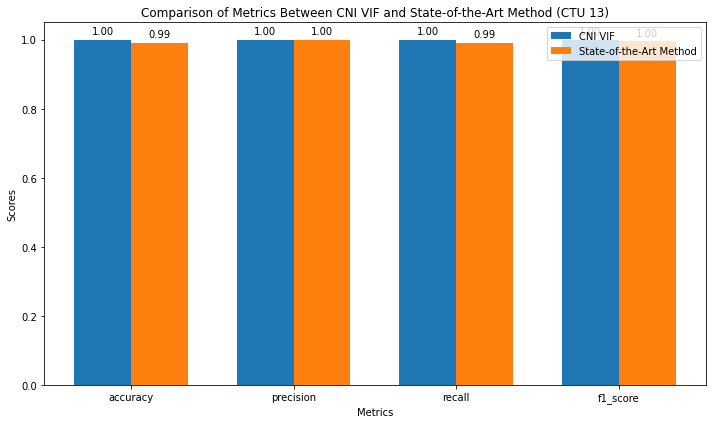

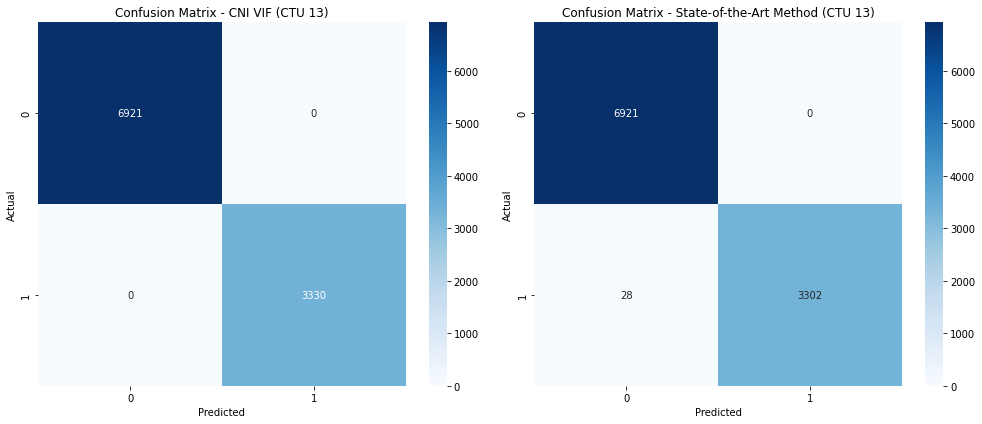

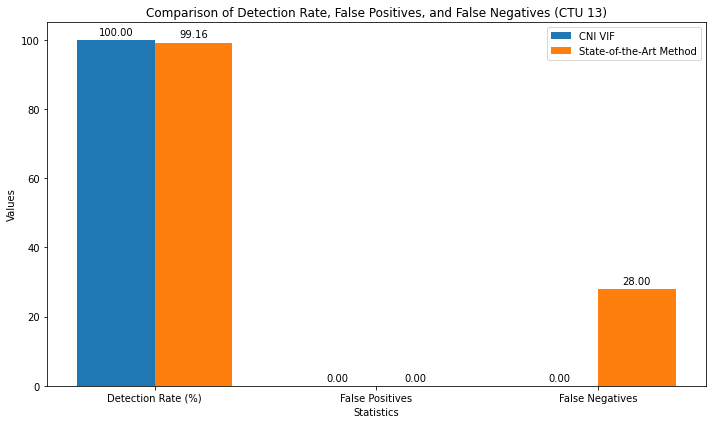

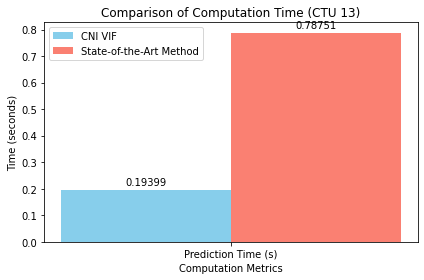

In [35]:
# Call the comparison function with the final results and dataset name
compare_results(results_cni_ctu, results_old_ctu, "CTU 13")

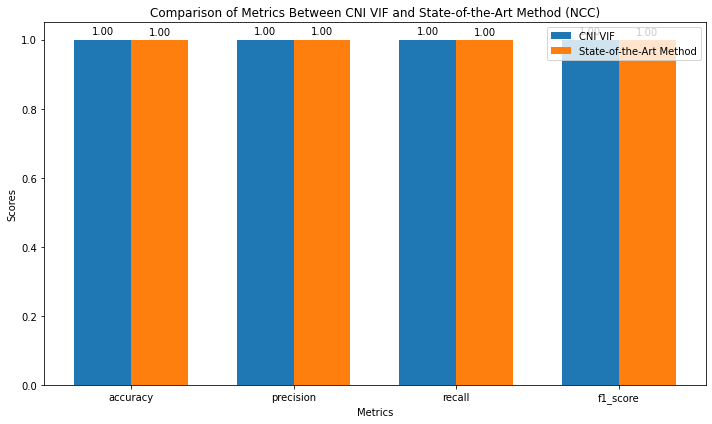

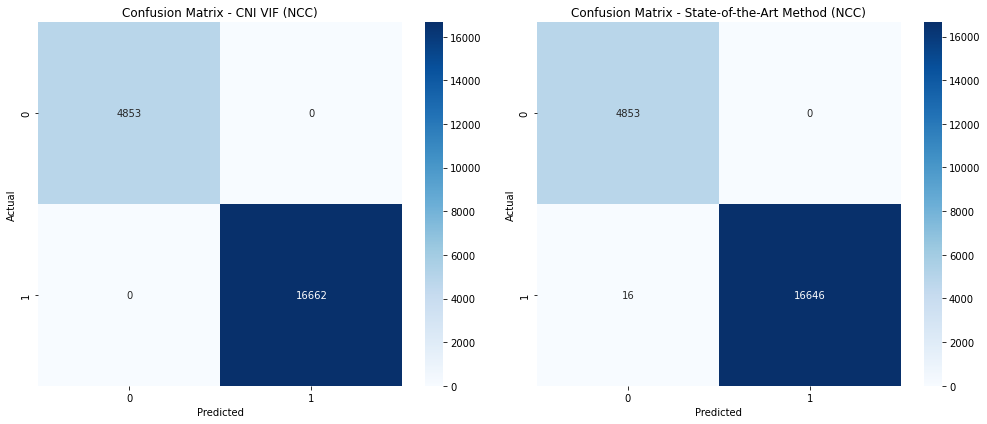

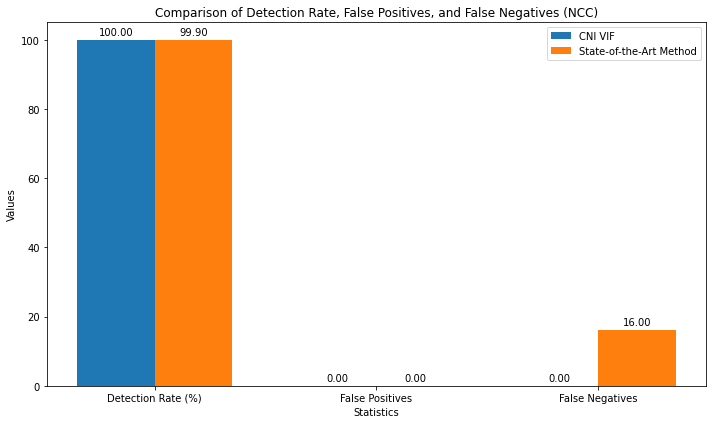

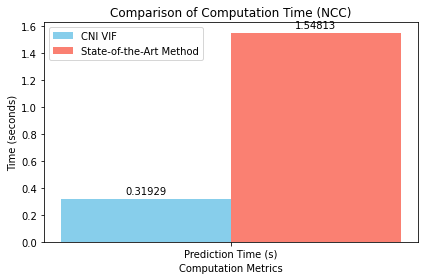

In [36]:
# Call the comparison function with the final results and dataset name
compare_results(results_cni_ncc, results_old_ncc, "NCC")


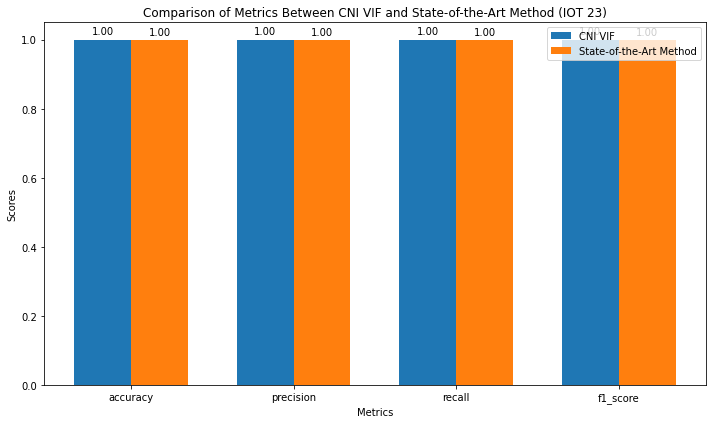

KeyError: 'confusion_matrix'

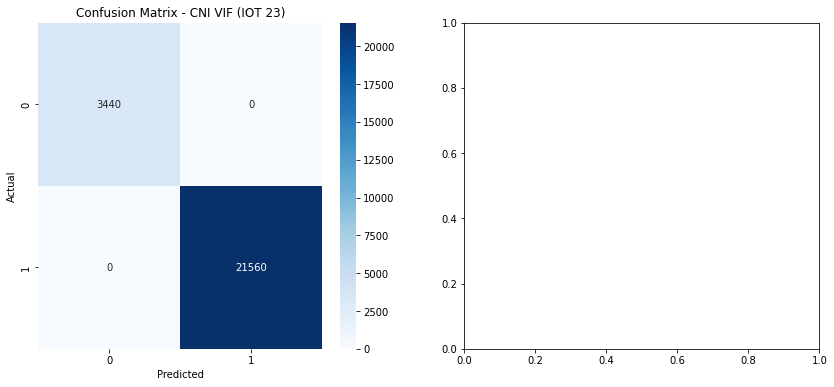

In [38]:
compare_results(results_cni_iot, results_old_iot, "IOT 23")